# Лабораторная работа №4

**Задача детекции**


**1.1 Задача детекции**
Данная лабораторная работа включает в себя следующие темы, пройденные на курсе: использование keras; все, что связано для использования сверточных нейронных сетей; transfer learning.

**Задача:** предоставлен датасет, содержащий фотографии разных размеров (JPEG-формата) кошек и собак. Необходимо:

1. Прочитать датасет, преобразовать фотографии к необходимому формату.
2. Разделить датасет на тренировочные и валидационные данные.
3. Написать и обучить сверточный автоэнкодер на фотографиях.
4. Соединить кодировщик автоэнкодера с новой написанной нейросетью "головой" на вход которой будет поступать закодированное представление фотографий от кодировщика, а на выходе выводится ответ на задачу многоклассовой классификации — на фотографии кошка или собака.

**1.2 Некоторые советы и требования**
* Для последней, финальной сети, предсказывающей класс изображения, лучше использовать metrics = [’accuracy’] для того, чтобы было проще сравнивать полученные результаты разных саданчок.
* В качестве метода для чтения датасета можно использовать ImageDataGenerator.flow_from_directory (это поможет и для создания датасета для обучения автоэнкодера).
* Т.к. фотографии разных размеров, то предлагается привести их к, например, размеру 32x32 или 64x64. Слишком большой размер фотографий советуем не ставить, но эксперименты с любыми параметрами при создании датасета (например, аугментация) очень приветствуются.
* Архитектура автоэнкодера и "головы" финальной сети не регламентирована заданием, все на усмотрение выполняющего.
* Размерность пространства скрытых признаков, получаемых на выходе кодировщика, не должна превышать 10% от количества цветных пикселей фотографий после приведения к единому размеру.
* Использование таких слоев, как Dropout и BatchNormalization, может упростить обучение нейросети.
* Для отслеживания процесса обучения нейросети можно использовать callback из сторонней библиотеки livelossplot под названием PlotLossesKeras.

**Требования:**
* Код в jupyter-ноутбуке.
* Графики обучения нейросетей (loss, accuracy).
* Вывод изначальных фотографий + полученных после прохождения через автоэнкодер.
* Некоторое количество фотографий + реальные и предсказанные финальной нейросетью классы.

## Импорт библиотек и подготовка данных

### Импорт необходимых библиотек

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2DTranspose, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from livelossplot import PlotLossesKeras
import os

# Убедимся, что TensorFlow использует GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Используется GPU:", physical_devices)
else:
    print("Используется CPU.")

Используется CPU.


## Автоэнкодер

### Подготовка данных

In [7]:
# Путь к папке с данными
data_dir = r'train/'

# Параметры
image_size = (64, 64)  # Размер изображения
batch_size = 32


# Создаем генераторы данных
datagen = ImageDataGenerator( # 80% для тренировки, 20% для тестирования + аугментация 
    rescale=1./255, 
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
) 

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input',  
    subset='training',
    shuffle=True
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='input', 
    subset='validation',
    shuffle=True
)


Found 13326 images belonging to 2 classes.
Found 3331 images belonging to 2 classes.


**Визуализация некоторых изображений из датасета**

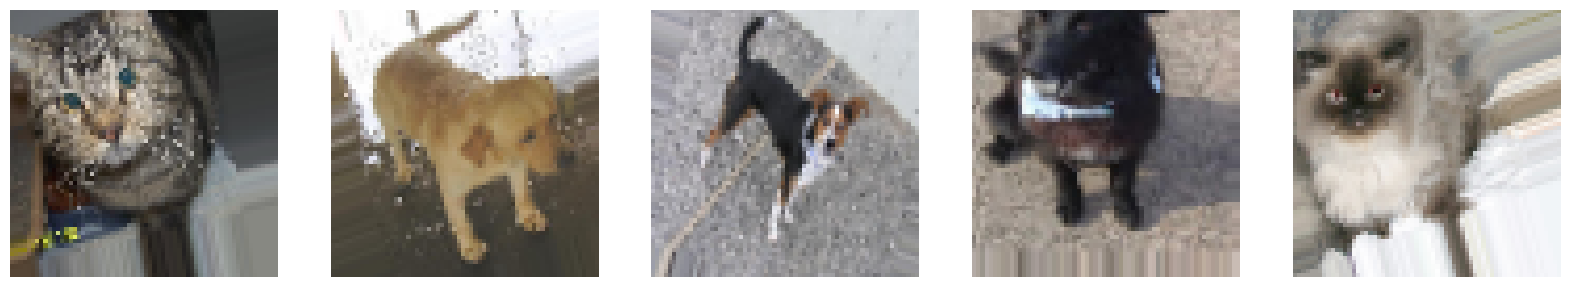

In [8]:
# Функция для отображения изображений
def plot_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.show()

images = next(train_generator)
plot_images(images[0][:5])


Качество шакальное)

### Создание функции для автоэнкодера

In [85]:
def create_autoencoder(input_shape):
    encoder_input = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    encoder_output = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoder = Model(encoder_input, encoder_output, name="encoder")

    
    x = BatchNormalization()(encoder_output)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    decoder_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    decoder = Model(encoder_input, decoder_output, name="decoder")

    autoencoder = Model(encoder_input, decoder(encoder_input))
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder, encoder


input_shape = (image_size[0], image_size[1], 3)
autoencoder, encoder = create_autoencoder(input_shape)



Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         187651    
                                                                 
Total params: 187,651
Trainable params: 187,011
Non-trainable params: 640
_________________________________________________________________


In [9]:
def create_autoencoder(input_shape):
    encoder_input = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    encoder_output = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    encoder = Model(encoder_input, encoder_output, name="encoder")

    x = BatchNormalization()(encoder_output)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    
    decoder_output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    decoder = Model(encoder_input, decoder_output, name="decoder")

    autoencoder = Model(encoder_input, decoder(encoder_input))
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder, encoder


input_shape = (image_size[0], image_size[1], 3)
autoencoder, encoder = create_autoencoder(input_shape)



In [10]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 decoder (Functional)        (None, 64, 64, 3)         3142531   
                                                                 
Total params: 3142531 (11.99 MB)
Trainable params: 3139587 (11.98 MB)
Non-trainable params: 2944 (11.50 KB)
_________________________________________________________________


In [11]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 64, 64, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1849

### Обучение автоэнкодера


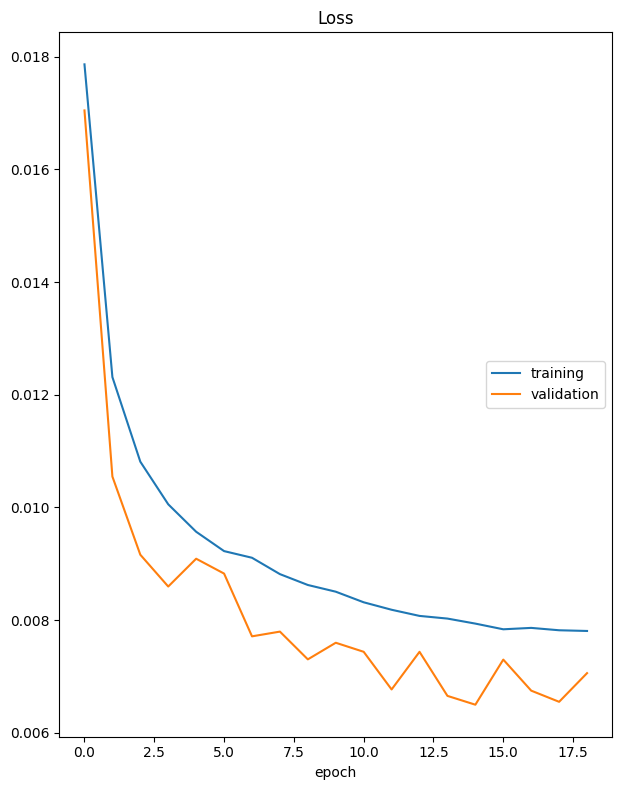

Loss
	training         	 (min:    0.008, max:    0.018, cur:    0.008)
	validation       	 (min:    0.006, max:    0.017, cur:    0.007)

Epoch 19: val_loss did not improve from 0.00650
417/417 [==============================] - 234s 562ms/step - loss: 0.0078 - val_loss: 0.0071
Epoch 20/50
334/417 [=======================>......] - ETA: 42s - loss: 0.0077

KeyboardInterrupt: 

In [12]:
# Обучение автоэнкодера
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
plot_losses = PlotLossesKeras()
checkpoint = ModelCheckpoint("best_autoencoder.h5", monitor='val_loss', save_best_only=True, verbose=1)

autoencoder.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, plot_losses, checkpoint]
)


1/1 [==============================] - 0s 118ms/step


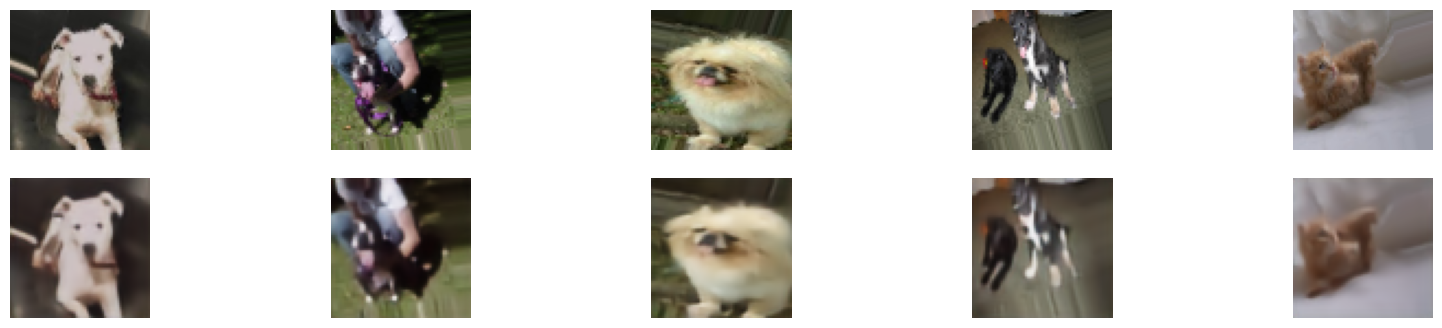

In [89]:
# Функция для визуализации оригинальных и восстановленных изображений
def plot_autoencoder_results(original_images, decoded_images, num_images=5):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Оригинальные изображения
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i])
        plt.axis('off')

        # Восстановленные изображения
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(decoded_images[i])
        plt.axis('off')
    plt.show()

# Пропуск изображений через автоэнкодер
decoded_images = autoencoder.predict(images[0][:5])
# Визуализация оригинальных и восстановленных изображений
plot_autoencoder_results(images[0][:5], decoded_images)

## Нейронка для классификации

### Подготовка данных

In [90]:
# Поделим на наборы данных с метками
train_generator_with_labels = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator_with_labels = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 19997 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.


In [95]:
early_stopping_full = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint_full = ModelCheckpoint("best_classifier.h5", monitor='val_loss', save_best_only=True, verbose=1)
plot_losses_full = PlotLossesKeras()


# Заморозка слоев кодировщика
#for layer in encoder.layers:
#    layer.trainable = False
    

# Функция для построения полной модели

def create_full_model(encoder, input_shape):
    encoded_input = encoder.output
    x = Flatten()(encoded_input)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    classifier = Model(encoder.input, x, name="classifier")
    classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return classifier
    
# Создание классификатора
classifier = create_full_model(encoder, input_shape)
classifier.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_64 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 batch_normalization_57 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 dropout_43 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_65 (Conv2D)          (None, 32, 32, 64)        1

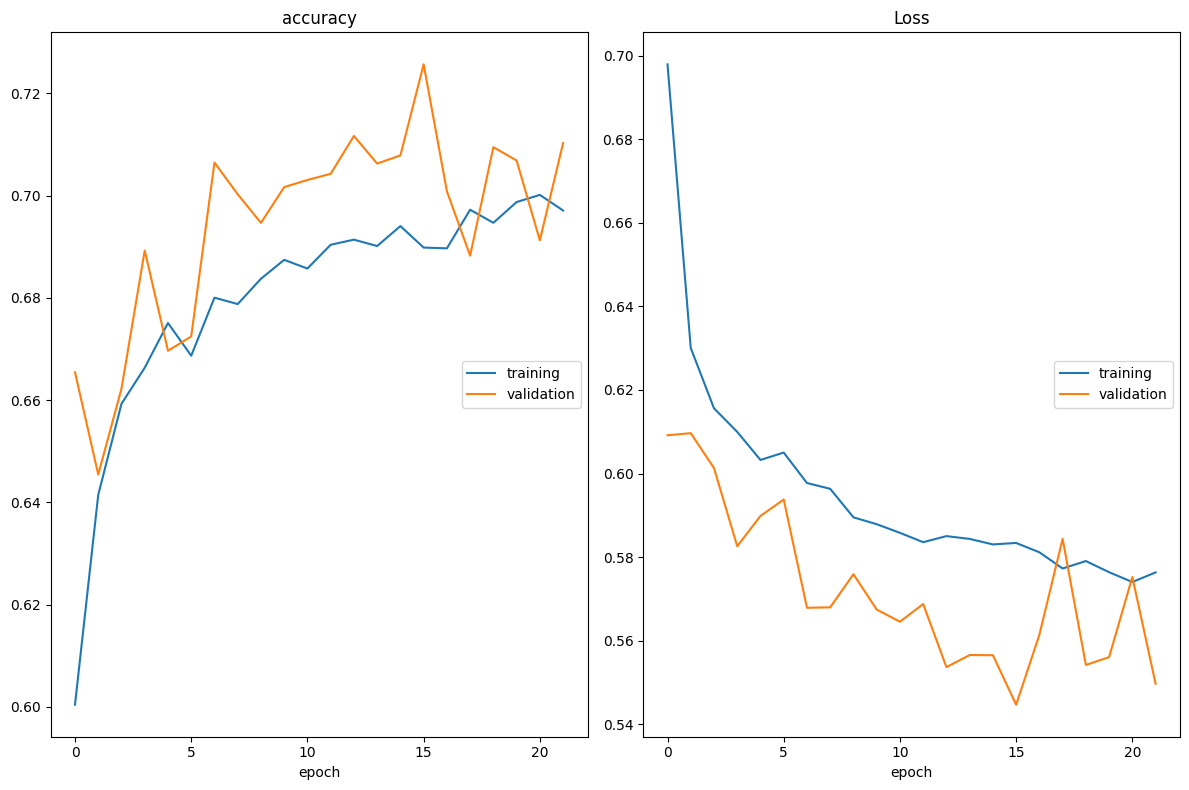

accuracy
	training         	 (min:    0.600, max:    0.700, cur:    0.697)
	validation       	 (min:    0.645, max:    0.726, cur:    0.710)
Loss
	training         	 (min:    0.574, max:    0.698, cur:    0.576)
	validation       	 (min:    0.545, max:    0.610, cur:    0.550)

Epoch 22: val_loss did not improve from 0.54467
625/625 [==============================] - 52s 84ms/step - loss: 0.5763 - accuracy: 0.6971 - val_loss: 0.5497 - val_accuracy: 0.7103
Epoch 23/50
625/625 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.7015

In [ ]:
classifier.fit(
    train_generator_with_labels,
    steps_per_epoch=len(train_generator_with_labels),
    epochs=50,
    validation_data=validation_generator_with_labels,
    validation_steps=len(validation_generator_with_labels),
    callbacks=[early_stopping_full, plot_losses_full, checkpoint_full]
)


In [ ]:
# Визуализация предсказаний
def plot_predictions(generator, model):
    x, y = next(generator)
    y_pred = (model.predict(x) > 0.5).astype(int)
    plt.figure(figsize=(20, 8))
    for i in range(10):
        ax = plt.subplot(4, 10, i + 1)
        plt.imshow(x[i])
        plt.axis('off')
        ax = plt.subplot(4, 10, i + 11)
        plt.text(0.5, 0.5, f'True: {int(y[i])}\nPred: {y_pred[i][0]}', fontsize=12, ha='center', va='center')
        plt.axis('off')
    plt.show()

plot_predictions(validation_generator_with_labels, classifier)